## 9 RtR: MultiOutput Trials

In [1]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

In [ ]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# Custom Handmade Modules (please copy folder to Colab Notebooks root)
from modules import performance_measures_helper as pms
import importlib # for continuous reloading

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

# Scikit-Learn
from sklearn.model_selection import train_test_split

### 6.1 Loading `targets` (raw + quantized)

Multitarget Analysis for Target Selection

In [3]:
# raw_targets (Regress-then-Rank baseline problems)
targets = pd.read_csv(
    PATH + "fx_data/20220929_FX_raw_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [4]:
targets.head()

,symbols,t_RAWRET1D,t_MOM1W,t_MOM2W,t_MOM1M,t_MOM3M,t_EWVOL3M,t_SRET1D,t_SRET3D,t_SRET1W,...,t_RACHEV6M99,t_RACHEV6M95,t_RACHEV6M90,t_RACHEV6M80,t_SORTINO1M,t_SORTINO3M,t_SORTINO6M,t_OMEGA1M,t_OMEGA3M,t_OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-24,AUD,0.006140,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-24,CAD,-0.009400,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-24,CHF,-0.002923,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-24,DKK,-0.000094,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-24,GBP,0.002996,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


### 6.2 Loading `features`

Next, we load 46 features based on performance, risk and past returns measures for the G11 currencies, excluding € which is considered as base currency

In [11]:
predictors = pd.read_csv(
    PATH + "fx_data/20220930_FX_reduced_features.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [12]:
predictors.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


### 6.3 Feature Engineering and Baseline Modeling with `LinearRegression()`

In [14]:
data = pd.merge(
    predictors,
    targets,
    how="inner",
    on=["Date","symbols"]    
)

In [15]:
data.tail()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,t_RACHEV6M99,t_RACHEV6M95,t_RACHEV6M90,t_RACHEV6M80,t_SORTINO1M,t_SORTINO3M,t_SORTINO6M,t_OMEGA1M,t_OMEGA3M,t_OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-29,JPY,0.012121,0.017806,-0.007876,0.005136,0.113193,-1.341665,-0.677560,0.760193,0.789695,...,29.713701,11.730133,6.684602,3.437627,-0.017319,-0.000051,-0.008237,0.791138,0.999108,0.880002
2022-09-29,NOK,-0.018502,-0.030445,-0.053177,-0.003796,0.104257,-0.321431,-1.079341,-1.259888,-1.465918,...,21.663397,11.287347,6.736532,3.376912,-0.053072,-0.006932,-0.014187,0.414838,0.867722,0.764384
2022-09-29,NZD,-0.006492,-0.022662,-0.037018,-0.010162,0.084419,0.687908,-0.684954,-0.545918,-1.347578,...,19.264163,10.789876,6.634187,3.452138,-0.036007,-0.005034,-0.011434,0.349518,0.878612,0.754133
2022-09-29,SEK,0.000702,-0.020642,-0.018687,-0.014614,0.059045,0.113245,0.637721,0.084411,-1.754968,...,25.331388,12.140380,7.345273,3.711804,-0.011847,-0.002648,-0.006000,0.484508,0.857934,0.764439
2022-09-29,USD,0.012623,0.028415,0.032642,0.074759,0.108251,-1.691498,-0.159152,0.827814,1.317673,...,17.987149,84.031415,23.590468,5.358535,3.346721,3.881856,3.549928,1.381393,1.448394,1.410853


* Custom **Train, Test** Split:

No shuffling possible here. If sequential calibration -> _Walk-Forward Analysis_

In [16]:
total_instances = len(data.index)
total_instances

47540

In [17]:
instances_by_date = data["symbols"].nunique()

In [18]:
total_dates = total_instances/instances_by_date
total_dates

4754.0

In [19]:
test_dates = data["2019":].index.nunique() # Initial Guess for All The Initial Sample Under Consideration (Different for Sequential Training)
test_fraction = test_dates/total_dates
print(f"Train/Test Ansatz Split: ({100*(1-test_fraction):.1f}%, {100*test_fraction:.1f}%)")

Train/Test Ansatz Split: (79.4%, 20.6%)


In [20]:
train_dates = total_dates-test_dates
split = int(total_instances*(1-test_dates/total_dates))
split

37770

In [21]:
train = data.iloc[:split]
train.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,t_RACHEV6M99,t_RACHEV6M95,t_RACHEV6M90,t_RACHEV6M80,t_SORTINO1M,t_SORTINO3M,t_SORTINO6M,t_OMEGA1M,t_OMEGA3M,t_OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,63.285780,20.957684,10.634051,4.343323,-0.074793,-0.024475,-0.005551,0.399540,0.720966,0.888010
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,25.189274,10.838796,6.235742,3.243489,-0.034162,0.317190,-0.007811,0.679049,1.034088,0.841193
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,230.731572,24.374586,9.441598,4.195457,3.643890,4.090608,0.967660,1.442073,1.449270,1.112966
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,115.424665,18.682533,9.228229,4.331279,1.944233,3.176223,0.288248,1.265031,1.466715,1.034997
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,64.096669,117.876736,18.172619,5.725537,-0.001465,0.122440,1.882566,0.965561,1.014667,1.242172


In [22]:
test = data.iloc[split:]
test.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,t_RACHEV6M99,t_RACHEV6M95,t_RACHEV6M90,t_RACHEV6M80,t_SORTINO1M,t_SORTINO3M,t_SORTINO6M,t_OMEGA1M,t_OMEGA3M,t_OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,AUD,-0.010183,-0.031430,-0.057585,-0.009233,0.082779,-0.989273,-1.792159,-0.873276,-1.905997,...,31.736482,13.635019,7.356091,3.509690,-0.055484,0.073314,-0.003267,0.334933,1.008967,0.861996
2019-01-01,CAD,-0.008502,-0.026926,-0.039187,-0.055194,0.069292,-0.840631,-1.896561,-0.871092,-1.950686,...,41.061530,14.139756,8.026986,3.897744,-0.032574,-0.010226,-0.001158,0.303275,0.627256,0.948515
2019-01-01,CHF,-0.005123,-0.004946,0.000353,0.005299,0.044046,-2.218748,-0.470495,-0.825688,-0.563713,...,46.869897,102.243233,16.895959,5.290702,2.623493,1.939893,2.148490,1.355545,1.247971,1.274016
2019-01-01,DKK,-0.000013,0.000121,-0.000526,-0.001426,0.002342,0.363128,-1.388600,-0.040454,0.258404,...,21.530760,10.601922,6.514687,3.259650,-0.000009,-0.000007,-0.000005,0.693965,0.702451,0.782238
2019-01-01,GBP,-0.006317,-0.003103,-0.014297,-0.017200,0.065932,-0.258839,-0.637818,-0.680212,-0.236271,...,79.893878,17.992783,8.930159,4.051136,-0.004116,-0.003329,-0.001142,0.811229,0.856402,0.935074


In [23]:
# All In (Scaled Returns Next Month) 
# However, it is clear there is no linear relation and multicolinearity between predictors
corr = train.corr()
corr.style.background_gradient(
    cmap="coolwarm",
    vmin=-1,
    vmax=1
).set_precision(2)


/tmp/ipykernel_41080/979805347.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(


In [50]:
bool_targets = train.columns.str.contains("t_6M") & ~train.columns.isin(["symbols"])
bool_predictors = ~train.columns.str.startswith("t_") & ~train.columns.isin(["symbols"])

In [52]:
train.columns[bool_targets]

Index([], dtype='object')

In [32]:
## Reconfiguring for sklearn, tf-keras
# Train Set
y_train = train.loc[:,bool_targets]
X_train = train.loc[:,bool_predictors] # Initially we does not consider to encode Currency as an Additional Feature

# Test Set 
y_test = test.loc[:,bool_targets]
X_test = test.loc[:,bool_predictors]

In [33]:
X_train

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,-1.570884,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,-1.053603,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,0.689485,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,0.115450,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,-0.226643,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,1.185568,...,216.914950,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691e+00,2.186265,1.454315,1.114922
2018-12-31,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,-1.383402,...,21.397244,10.474178,6.250253,3.375089,-0.018078,-0.010236,-4.652841e-03,0.475308,0.505669,0.706600
2018-12-31,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,-1.079546,...,369.671432,22.298551,9.786237,4.426369,-0.027664,1.937340,3.991598e-01,0.601019,1.237701,1.047407


#### 6.3.1 Baseline Naive Linear Regression (`sklearn`)

<AxesSubplot:ylabel='Density'>

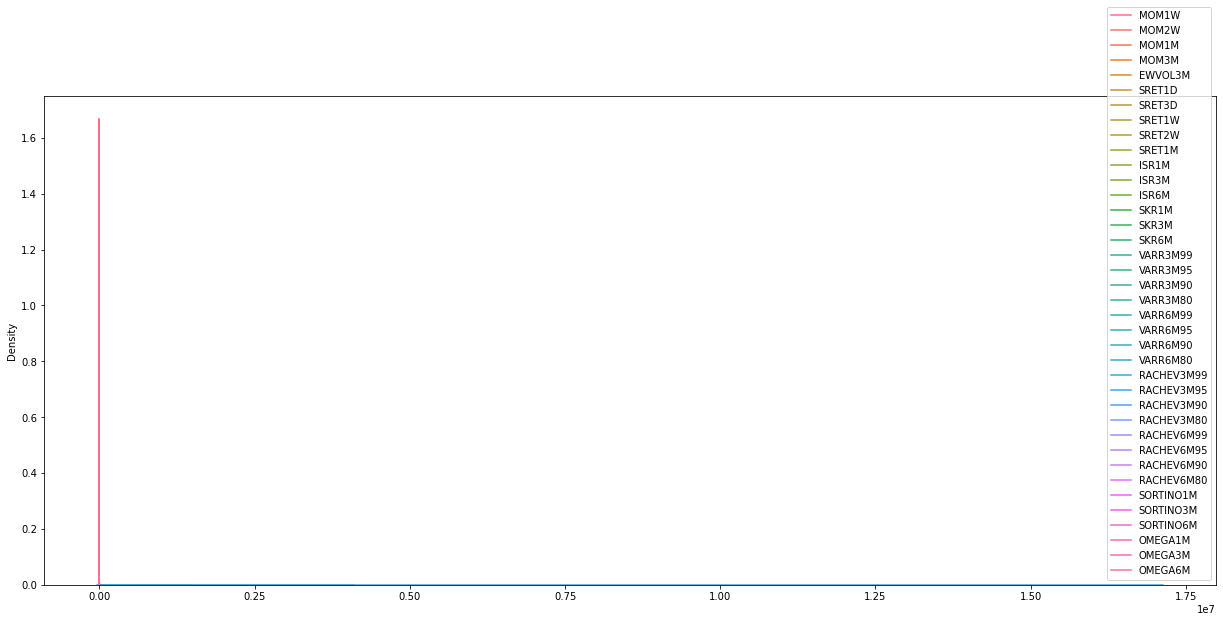

In [35]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(21,9))
sns.kdeplot(data=X_train)

In [36]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

rb = RobustScaler()
minmax = MinMaxScaler()
std = StandardScaler()

In [41]:
X_train_std_scaled = std.fit_transform(X_train)
X_test_std_scaled = std.transform(X_test)

X_train_rb_scaled = rb.fit_transform(X_train)
X_test_rb_scaled = rb.transform(X_test)

X_train_minmax_scaled = minmax.fit_transform(X_train)
X_test_minmax_scaled = minmax.transform(X_test)

<AxesSubplot:ylabel='Density'>

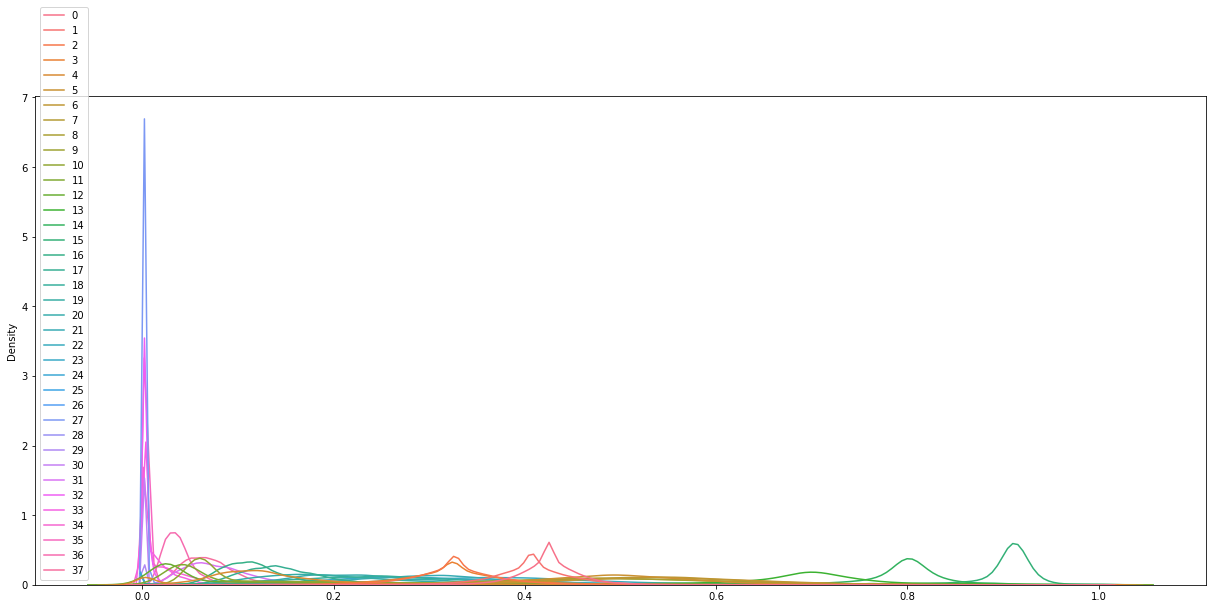

In [44]:
fig, ax = plt.subplots(figsize=(21,9))

sns.kdeplot(data=X_train_minmax_scaled)

In [58]:
y_train[["t_OMEGA6M"]]

,t_OMEGA6M
Date,
2004-05-25,0.888010
2004-05-25,0.841193
2004-05-25,1.112966
2004-05-25,1.034997
2004-05-25,1.242172
...,...
2018-12-31,1.143586
2018-12-31,0.740584
2018-12-31,1.034802


In [59]:
# LR Supports MultiOutput By Default. Therefore Trial for Best Target to Regress is Straightforward
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

scores_dict = dict()

for target in y_train.columns:
    
    lr.fit(
        X_train_minmax_scaled,
        y_train[target]
    )
    scores_dict[target]=lr.score(X_test_minmax_scaled, y_test[target])


In [81]:
LR_scores_df = pd.DataFrame(scores_dict,index=["R2"]).T

<AxesSubplot:>

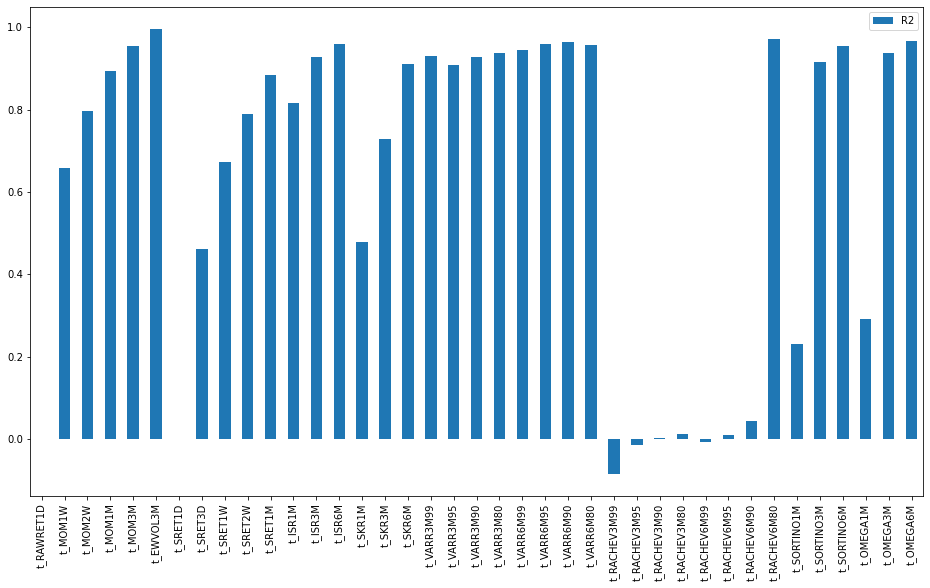

In [87]:
LR_scores_df.plot.bar(figsize=(16,9))

In [79]:
LR_scores_df.sort_values(by=["R2"],ascending=False).head()

,R2
t_EWVOL3M,0.994362
t_RACHEV6M80,0.971023
t_OMEGA6M,0.966162
t_VARR6M90,0.964963
t_ISR6M,0.959424


In [88]:
X_train.tail()

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,1.185568,...,216.914950,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691,2.186265,1.454315,1.114922
2018-12-31,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,-1.383402,...,21.397244,10.474178,6.250253,3.375089,-0.018078,-0.010236,-0.004653,0.475308,0.505669,0.706600
2018-12-31,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,-1.079546,...,369.671432,22.298551,9.786237,4.426369,-0.027664,1.937340,0.399160,0.601019,1.237701,1.047407
2018-12-31,0.000840,-0.003125,0.005169,0.012791,0.059882,0.691579,0.754762,0.099591,-0.261942,0.299010,...,58.829053,13.671854,7.324387,3.447077,1.458125,1.384202,-0.000100,1.156082,1.150455,0.993588
2018-12-31,-0.005868,-0.011713,-0.004124,0.009773,0.064648,-0.190858,-0.302625,-0.644430,-0.909517,-0.220985,...,119.368106,30.502123,10.887670,4.227297,-0.001967,0.966508,1.064030,0.884290,1.104506,1.118376


In [89]:
print(f"{X_train['2017':'2018'].shape[0]/10}")
print(f"{X_train.shape[0]/10}")

validation_dates = X_train['2017':'2018'].shape[0]/10
all_train_dates = X_train.shape[0]/10

validation_fraction_ = validation_dates/all_train_dates
print(f"{100*validation_fraction_:.2f}%")

519.0
3777.0
13.74%


In [90]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=[512],
    random_state=20221101,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=validation_fraction_, #2y (with no shuffle) for validation
    shuffle=False    
    )

mlp.fit(X_train_minmax_scaled, y_train[["t_OMEGA6M"]].values.ravel())
pred = mlp.predict(X_train_minmax_scaled)

In [92]:
y_test[["t_OMEGA6M"]]

,t_OMEGA6M
Date,
2019-01-01,0.861996
2019-01-01,0.948515
2019-01-01,1.274016
2019-01-01,0.782238
2019-01-01,0.935074
...,...
2022-09-29,0.880002
2022-09-29,0.764384
2022-09-29,0.754133


In [94]:
# In-Sample (Very Good Fitting... For Regression)
print(f"Train R^2: {100*mlp.score(X_train_minmax_scaled, y_train[['t_OMEGA6M']]):.2f}%") # Poor Signal-To-Noise Ratio
# Out-Of-Sample (Very Good As Well)
print(f"Test R^2: {100*mlp.score(X_test_minmax_scaled, y_test[['t_OMEGA6M']]):.2f}%")

Train R^2: 92.05%
Test R^2: 94.94%


**CONCLUSIONS (LR and MLP with All Features)**

1. Plain-Vanilla Linear and MLP Models when considering the whole sample and with a 80%, 20% split, are working reasonably well if the 6M-window Omega Ratio observed one-period ahead is chosen as the target (response). Other Targets with High $R^2$ on Test could be `EWVOL3M` (discarded, as a volatility indicator translating into ranks could be misleading), `RACHEV6M80`, `VARR6M90`, `ISR6M` (already analized)

2. Let us derive the OOS performances to get an insight if this finding is relevant or not in terms of forward cumulative returns

#### 6.3.2 Out-Of-Sample Performance

In [95]:
y_pred = mlp.predict(X_test_minmax_scaled)

In [96]:
predictions_tidy = test.loc[:,["symbols"]]
predictions_tidy["OMEGA6M_MLP"] = y_pred
predictions_tidy

,symbols,OMEGA6M_MLP
Date,,
2019-01-01,AUD,0.895634
2019-01-01,CAD,0.895340
2019-01-01,CHF,1.223929
2019-01-01,DKK,0.798896
2019-01-01,GBP,0.882027
...,...,...
2022-09-29,JPY,0.933763
2022-09-29,NOK,0.829264
2022-09-29,NZD,0.817203


In [104]:
predictions_tidy = test[["symbols","t_OMEGA6M"]].merge(
    predictions_tidy,
    on=["Date","symbols"]
)

<AxesSubplot:xlabel='Date'>

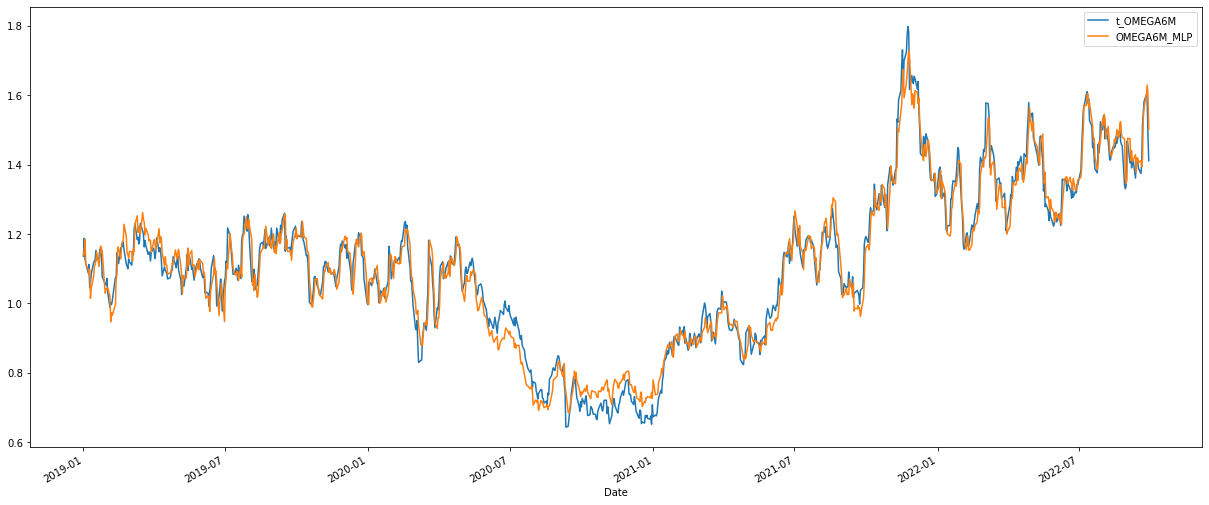

In [114]:
predictions_tidy.query("symbols=='USD'").iloc[:,-2:].plot(figsize=(21,9))

In [118]:
predictions_wide = pd.pivot(
    predictions_tidy.reset_index(),
    index=["Date"],
    columns="symbols",
    values="OMEGA6M_MLP"
)

In [121]:
predictions_rank_wide = predictions_wide.rank(axis=1)

In [122]:
best_curr = (predictions_rank_wide==10).shift(1)
worst_curr = (predictions_rank_wide==1).shift(1)

In [123]:
fx_prices = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [124]:
best_curr.head()

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,False,False,True,False,False,False,False,False,False,False
2019-01-03,False,False,True,False,False,False,False,False,False,False
2019-01-04,False,False,False,False,False,True,False,False,False,False
2019-01-07,False,False,False,False,False,True,False,False,False,False


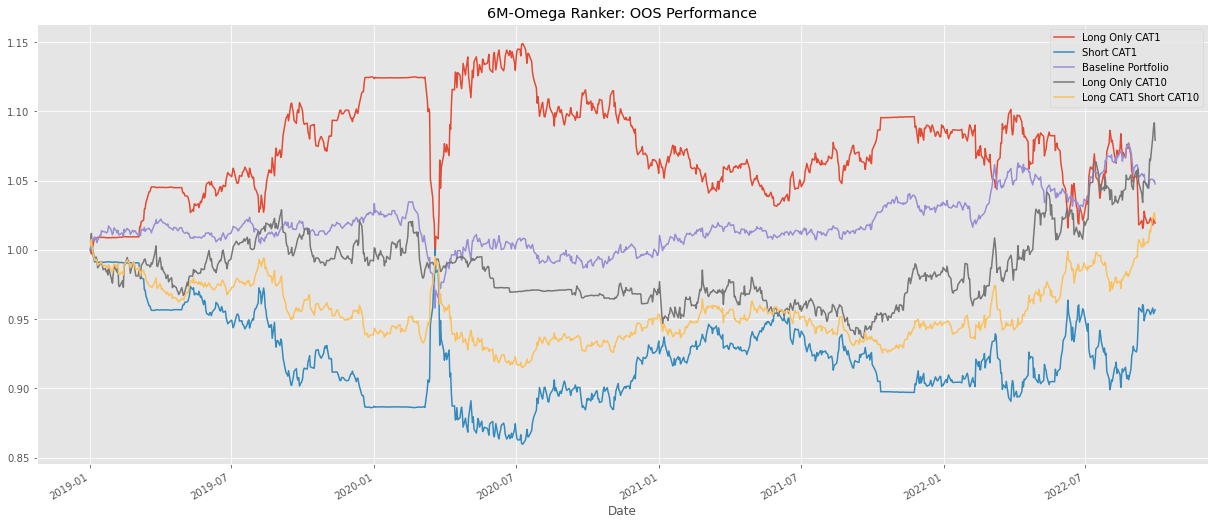

In [167]:
plt.style.use("ggplot")



(1+fx_prices.pct_change()[worst_curr].mean(axis=1)).rename("Long Only CAT1").cumprod().plot(legend=True);
(1-fx_prices.pct_change()[worst_curr].mean(axis=1)).rename("Short CAT1").cumprod().plot(legend=True);

(1+fx_prices.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(
    figsize=(21,9), 
    legend=True,
    title="6M-Omega Ranker: OOS Performance")
    
(1+fx_prices.pct_change()[best_curr].mean(axis=1)).rename("Long Only CAT10").cumprod().plot(legend=True);
(1+0.5*fx_prices.pct_change()[best_curr].mean(axis=1)-0.5*fx_prices.pct_change()[worst_curr].mean(axis=1)).rename("Long CAT1 Short CAT10").cumprod().plot(legend=True);


#plt.semilogy();


In [134]:
observed_rank_tidy = pd.read_csv(
    PATH + "fx_data/20220929_FX_quantized_targets.csv",
    usecols=["Date","symbols","t_qOMEGA6M"],
    index_col="Date",
    parse_dates=["Date"]
)

In [135]:
observed_rank_tidy

,symbols,t_qOMEGA6M
Date,,
2004-05-24,AUD,3.0
2004-05-24,CAD,1.0
2004-05-24,CHF,9.0
2004-05-24,DKK,8.0
2004-05-24,GBP,10.0
...,...,...
2022-09-29,JPY,5.0
2022-09-29,NOK,2.0
2022-09-29,NZD,1.0


In [136]:
predictions_wide

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,0.895634,0.895340,1.223929,0.798896,0.882027,1.142433,0.756867,1.049398,1.052024,1.138887
2019-01-02,0.898671,0.895025,1.271024,0.830674,0.906722,1.181119,0.750585,1.041938,1.047537,1.150695
2019-01-03,0.899406,0.937876,1.300574,0.825167,0.875157,1.353714,0.742546,1.054016,1.023654,1.184156
2019-01-04,0.912392,0.971126,1.262181,0.816128,0.879037,1.305484,0.789195,1.084869,1.030459,1.111451
2019-01-07,0.942083,0.993708,1.316148,0.827366,0.907182,1.279802,0.829318,1.101382,1.079730,1.098864
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,0.967182,1.263438,1.366443,0.955151,0.905666,0.940723,0.873458,0.858146,0.796329,1.563135
2022-09-26,0.933961,1.258208,1.371518,0.980242,0.784303,0.944529,0.891844,0.851957,0.804937,1.600987
2022-09-27,0.927035,1.249753,1.356181,0.975955,0.788559,0.951879,0.850818,0.842489,0.803880,1.628758


In [142]:
predictions_rank_tidy = (
    predictions_rank_wide.melt(    
        value_name="MLP_rank",
        ignore_index=False
    )
    .reset_index()
    .sort_values(by=["Date","symbols"])
    .set_index("Date")
)

In [144]:
accuracy_rank_df = observed_rank_tidy.merge(
    predictions_rank_tidy,
    how="inner",
    on=["Date","symbols"]
)

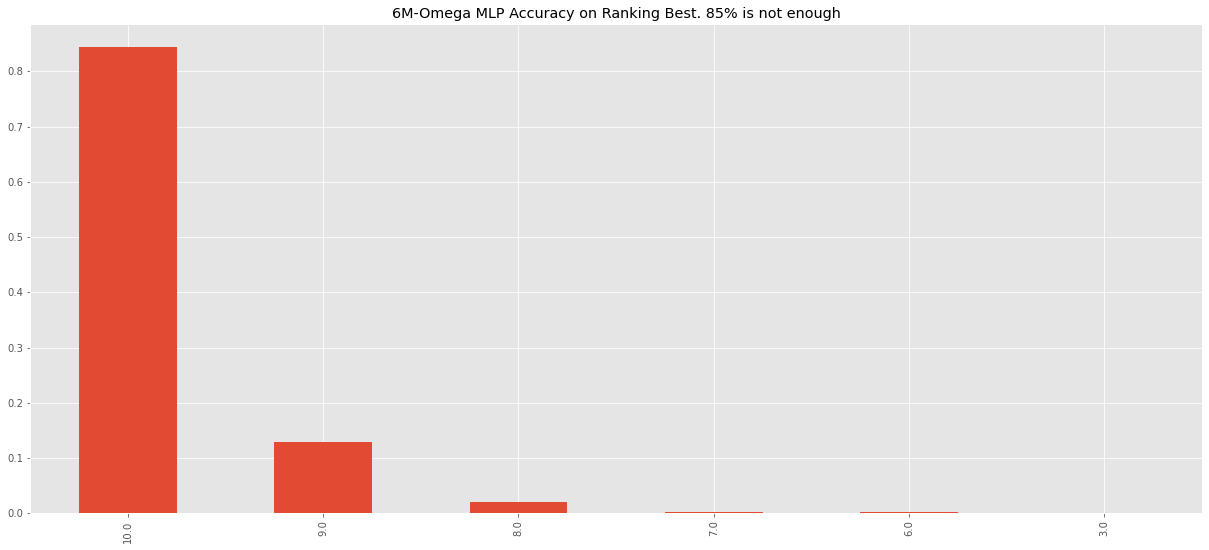

In [175]:
accuracy_rank_df.query("t_qOMEGA6M==10").iloc[:,-1].value_counts(normalize=True).plot.bar(
    figsize=(21,9),
    title="6M-Omega MLP Accuracy on Ranking Best. 85% is not enough"
);

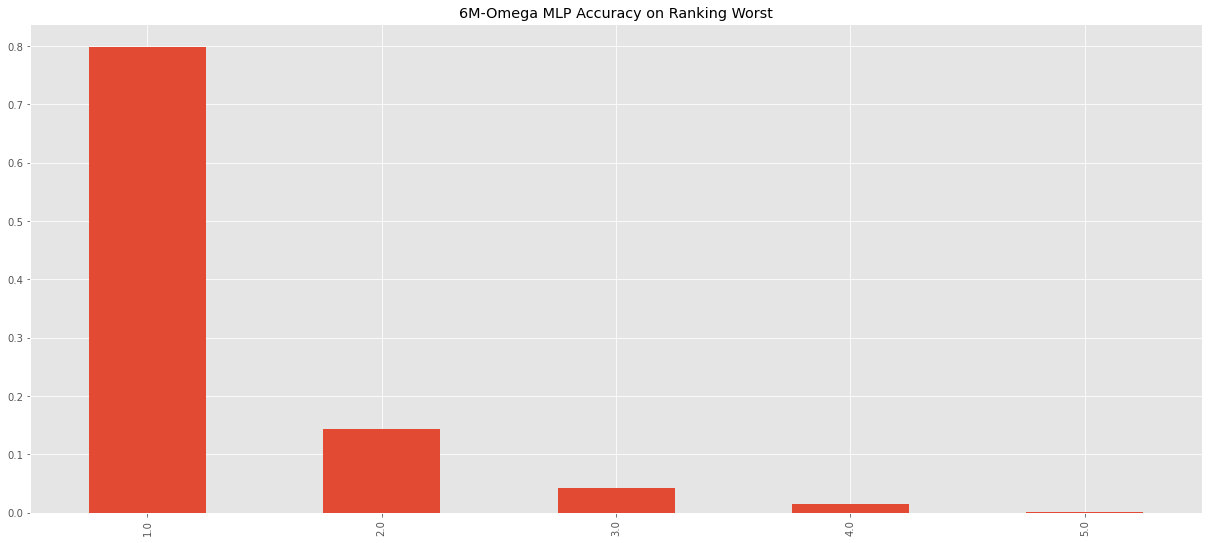

In [166]:
# Accuracy on Bad Performing Currencies
accuracy_rank_df.query("t_qOMEGA6M==1").iloc[:,-1].value_counts(normalize=True).plot.bar(
    figsize=(21,9),
    title="6M-Omega MLP Accuracy on Ranking Worst"
);

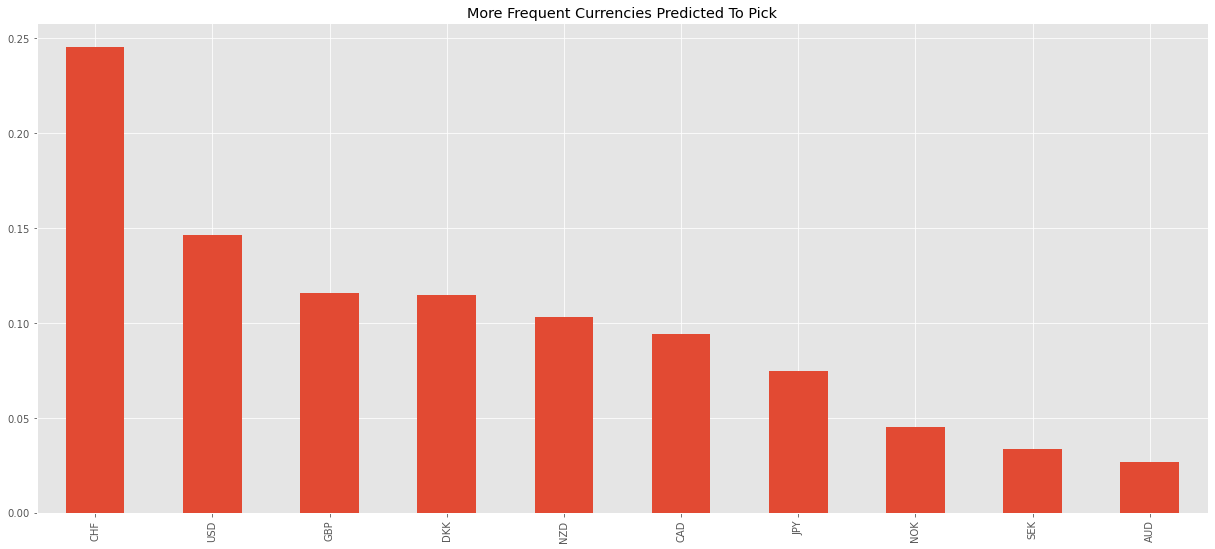

In [173]:
#FX Supremacies
accuracy_rank_df.query("MLP_rank==10").loc[:,"symbols"].value_counts(normalize=True).plot.bar(
    figsize=(21,9),
    title="More Frequent Currencies Predicted To Pick"
);

In [176]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
LR_scores_df            DataFrame                        R2\nt<...>9\nt_OMEGA6M     0.966162
X_test                  DataFrame                   MOM1W     <...>n[9770 rows x 38 columns]
X_train                 DataFrame                   MOM1W     <...>[37770 rows x 38 columns]
accuracy_rank_df        DataFrame               symbols  t_qOM<...>\n[9770 rows x 3 columns]
best_curr               DataFrame    symbols       AUD    CAD <...>\n[977 rows x 10 columns]
corr                    DataFrame                    MOM1W    <...>n\n[77 rows x 77 columns]
data                    DataFrame               symbols     MO<...>[47540 rows x 78 columns]
fx_prices               DataFrame                     AUD     <...>n[4880 rows x 10 columns]
observed_rank_tidy      DataFrame               symbols  t_qOM<...>n[47550 rows x 2 columns]
predictions_rank_tidy   DataFrame               symbols  MLP_r<...>\n

In [177]:
predictions_wide

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,0.895634,0.895340,1.223929,0.798896,0.882027,1.142433,0.756867,1.049398,1.052024,1.138887
2019-01-02,0.898671,0.895025,1.271024,0.830674,0.906722,1.181119,0.750585,1.041938,1.047537,1.150695
2019-01-03,0.899406,0.937876,1.300574,0.825167,0.875157,1.353714,0.742546,1.054016,1.023654,1.184156
2019-01-04,0.912392,0.971126,1.262181,0.816128,0.879037,1.305484,0.789195,1.084869,1.030459,1.111451
2019-01-07,0.942083,0.993708,1.316148,0.827366,0.907182,1.279802,0.829318,1.101382,1.079730,1.098864
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,0.967182,1.263438,1.366443,0.955151,0.905666,0.940723,0.873458,0.858146,0.796329,1.563135
2022-09-26,0.933961,1.258208,1.371518,0.980242,0.784303,0.944529,0.891844,0.851957,0.804937,1.600987
2022-09-27,0.927035,1.249753,1.356181,0.975955,0.788559,0.951879,0.850818,0.842489,0.803880,1.628758


##### Further Analysis: Other (Simplified) Quantizations

In [211]:
predictions_rank_wide_ventile = predictions_wide.apply(pd.qcut, q=5, labels=False, axis=1) # Ventile Based

In [212]:
predictions_rank_wide_ventile.apply(pd.value_counts, axis=1)

,0,1,2,3,4
Date,,,,,
2019-01-01,2,2,2,2,2
2019-01-02,2,2,2,2,2
2019-01-03,2,2,2,2,2
2019-01-04,2,2,2,2,2
2019-01-07,2,2,2,2,2
...,...,...,...,...,...
2022-09-23,2,2,2,2,2
2022-09-26,2,2,2,2,2
2022-09-27,2,2,2,2,2


In [215]:
mask_best = (predictions_rank_wide_ventile==4).shift(1).fillna(False)
mask_worst = (predictions_rank_wide_ventile==0).shift(1).fillna(False)

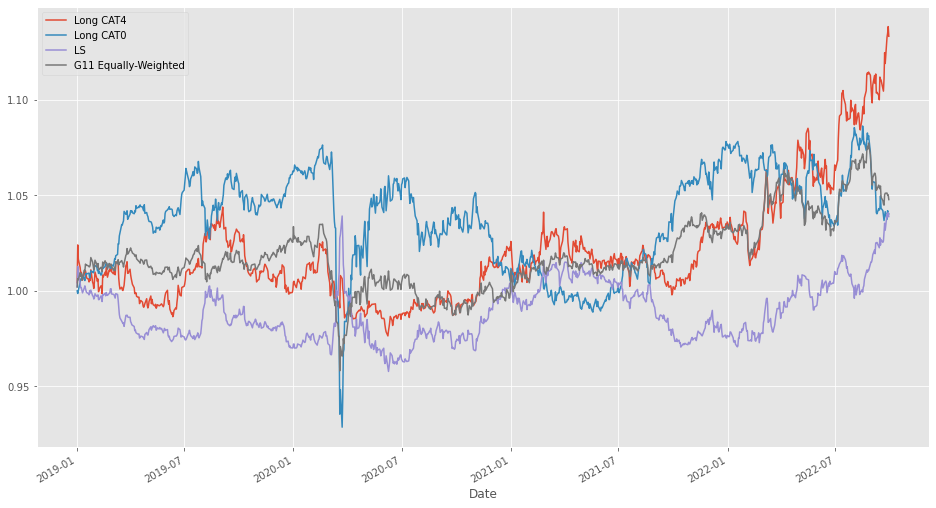

In [218]:
plot_args={
    "figsize": (16,9),
    "legend": True
}

mean_args = {
    "axis": 1,
    "skipna": True
}


(1+fx_prices.pct_change()[mask_best].mean(**mean_args)).cumprod().rename("Long CAT4").plot(**plot_args)
(1+fx_prices.pct_change()[mask_worst].mean(**mean_args)).cumprod().rename("Long CAT0").plot(**plot_args)
(1+0.5*fx_prices.pct_change()[mask_best].mean(**mean_args)-0.5*fx_prices.pct_change()[mask_worst].mean(**mean_args)).cumprod().rename("LS").plot(**plot_args)

(1+fx_prices[mask_best.index[0]:].pct_change().mean(**mean_args)).cumprod().rename("G11 Equally-Weighted").plot(
    **plot_args,
    title="Quantized Prediction Based On Ventile Ranking"
    );

